# Mutational and positional extrapolation

We tested the ability of the models to generalize to mutations and positions not present in the training data.

This notebook:
- Explains mutational and positional extrapolation
- Shows how to generate mutational and positional train/tune/test splits
- Visualizes those splits and some of the ones from the publication

To access the mutational and positional splits we used in the manuscript, see the the `pub/splits` directory.

In [1]:
# reload modules before executing code in order to make development and debugging easier
%load_ext autoreload
%autoreload 2

In [2]:
# this jupyter notebook is running inside of the "notebooks" directory
# for relative paths to work properly, we need to set the current working directory to the root of the project
# for imports to work properly, we need to add the code folder to the system path
import os
from os.path import abspath, join, isdir, basename
import sys
if not isdir("notebooks"):
    # if there's a "notebooks" directory in the cwd, we've already set the cwd so no need to do it again
    os.chdir("..")
module_path = abspath("code")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import constants
import split_dataset as sd
import utils

# set logging level to info
import logging
logging.basicConfig()
logger = logging.getLogger("nn4dms")
logger.setLevel(logging.INFO)

# Generate splits

Randomly dividing sequences into train/tune/test sets (as demonstrated in `train_test_split.ipynb`) supports training and evaluating models that make predictions for variants that have characteristics similar to the training data.
Here, we describe dataset splitting strategies that more directly test the ability of a model to generalize to mutations or positions that are not present in the training data.

### Mutational extrapolation

In mutational extrapolation, we designate X% of single mutations present in the dataset as training and Y% as testing. We then divide the variants into three pools: training, testing, or overlap, depending on whether the variants contain only mutations designated as training, only mutations designated as testing, or mutations from both sets. We discard the overlap pool to ensure there is no informational overlap between the training and testing data. We split the training pool into a train set and tune set, and use all the sequences in the testing pool as the test set.

### Positional extrapolation

For positional extrapolation, we follow a similar procedure as mutational extrapolation. We designate X% of sequence positions as training and Y% as testing. We divide variants into training, testing, and overlap pools, depending on whether the variants contain mutations only in positions designated as training, only in positions designated as testing, or both in positions designated as training and testing. Finally, we discard the overlap pool, split the training pool into a train and tune set, and use all sequences in the testing pool as the test set

Functions to generate mutational and positional split are located in `code/split_dataset.py`.

In [4]:
out_dir = "data/avgfp/example_splits"

# load the full dataset (really, we only need the # of variants in the dataset, but this is easier)
ds = utils.load_dataset(ds_name="avgfp")

# mutational  splits
train_muts_size = 0.8  # proportion of single mutations present in dataset to designate as training
tune_size = 0.1  # proportion of the training pool to use as the tune set (rest becomes test set)
rseed = 1
mut_split, mut_split_dir, mut_additional_info = sd.mutation_split(ds, train_muts_size, tune_size, out_dir=out_dir, rseed=rseed, overwrite=True)

# positional splits
seq_len = len(constants.DATASETS["avgfp"]["wt_aa"])
wt_ofs = constants.DATASETS["avgfp"]["wt_ofs"]
train_pos_size = 0.8  # proportion of sequence positions to designate as training
tune_size  # proportion of the training pool to use as the tune set (rest becomes test set)
rseed = 2
pos_split, pos_split_dir, pos_additional_info = sd.position_split(ds, seq_len, wt_ofs, train_pos_size, tune_size, out_dir=out_dir, rseed=rseed, overwrite=True)

INFO:nn4dms.split_dataset:number of unique mutations in ds: 1879
INFO:nn4dms.split_dataset:num_train_mutations: 1503, num_test_mutations: 376
INFO:nn4dms.split_dataset:train pool size: 22993, test pool size: 976, overlap pool size: 30055
INFO:nn4dms.split_dataset:num_train: 20693, num_tune: 2300, num_test: 976
INFO:nn4dms.split_dataset:saving train-tune-test split to directory data/avgfp/example_splits/mutation_tr-muts0.8_tu0.1_r1
INFO:nn4dms.split_dataset:num_train_positions: 190, num_test_positions: 47
INFO:nn4dms.split_dataset:train pool size: 23679, test pool size: 823, overlap pool size: 29522
INFO:nn4dms.split_dataset:num_train: 21311, num_tune: 2368, num_test: 823
INFO:nn4dms.split_dataset:saving train-tune-test split to directory data/avgfp/example_splits/position_tr-pos0.8_tu0.1_r2


# Visualize example splits
These plotting functions help visualize the mutational and positional splits.

In [5]:
def pos_split_heatmap(ds_name, seq_len, wt_ofs, split_name, split, additional_info, out_dir=None):
        
    # set up the heatmap
    sequence_heatmap = np.zeros((1, seq_len), dtype=int)
    sequence_heatmap[0, additional_info["pool_seq_positions"]["train"]] = 1
    sequence_heatmap[0, additional_info["pool_seq_positions"]["test"]] = 2
        
    # set up the color palette and mapping from values to labels
    num_cats = 2
    cmap = sns.color_palette("deep", num_cats)
    vmap = {1: "train", 2: "test"}

    # plot the heatmap
    fig, ax = plt.subplots(1, figsize = (12, 2))
    sns.heatmap(sequence_heatmap, square=False, linecolor="white", linewidths=0, cmap=cmap, ax=ax)

    # colorbar code from https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + 0.5 * r / (num_cats) + r * i / (num_cats) for i in range(num_cats)])
    colorbar.set_ticklabels(list(vmap.values()))

    # axis titles
    ax.set(title="Position-based split\n{}, {}".format(ds_name, basename(split_name)))
    ax.set(xlabel="Sequence position")
    ax.set(ylabel="{}".format(ds_name))
    ax.set_yticks([])

    plt.tight_layout()

    if out_dir is None:
        plt.show(fig)
        plt.close(fig)
    else:
        utils.mkdir(out_dir)
        fig.savefig(join(out_dir, "{}_{}_pospool.png".format(ds_name, split_name)), dpi=300)
        plt.close(fig)
        
def mut_split_heatmap(ds_name, wt_aa, seq_len, wt_ofs, split_name, split, additional_info, out_dir=None):
    # set up the heatmap
    all_muts = additional_info["pool_muts"]["train"] + additional_info["pool_muts"]["test"]
    pools_heatmap = np.zeros((seq_len, constants.NUM_CHARS), dtype=float)
    # training pool
    for mut in additional_info["pool_muts"]["train"]:
        pos = int(mut[1:-1])
        new_aa = mut[-1]
        pools_heatmap[pos - wt_ofs, constants.CHARS.index(new_aa)] = 1
    # testing pool
    for mut in additional_info["pool_muts"]["test"]:
        pos = int(mut[1:-1])
        new_aa = mut[-1]
        pools_heatmap[pos - wt_ofs, constants.CHARS.index(new_aa)] = 2
    # wild-type AAs
    for i, aa in enumerate(wt_aa):
        pools_heatmap[i, constants.CHARS.index(aa)] = 3


    # set up the color palette and mapping from values to labels
    num_cats = 4
    cmap = sns.color_palette("deep", num_cats)
    cmap = ["lightgray", sns.color_palette()[0], sns.color_palette()[1], "darkgray"]
    # zero is mutation not in dataset (or wild-type aa)
    vmap = {0:"n/a", 1: "train", 2: "test", 3:"wt"}

    # plot the heatmap
    fig, ax = plt.subplots(1, figsize = (6, seq_len / 7))
    sns.heatmap(pools_heatmap, square=False, linecolor="white", linewidths=0.5, cmap=cmap, ax=ax)

    # colorbar code from https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + 0.5 * r / (num_cats) + r * i / (num_cats) for i in range(num_cats)])
    colorbar.set_ticklabels(list(vmap.values()))
    
    # tick rotation
    ax.tick_params(axis='y', labelrotation = 0)

    # axis titles
    ax.set(title="Mutation-based split\n{}, {}".format(ds_name, split_name))
    ax.set(ylabel="Sequence position", xlabel="Substituting AA")
    ax.set_xticklabels(constants.CHARS)
    ax.set_yticklabels([int(ytick.get_text()) + wt_ofs for ytick in ax.get_yticklabels()])
    
    if out_dir is None:
        plt.show(fig)
        plt.close(fig)
    else:
        utils.mkdir(out_dir)
        fig.savefig(join(out_dir, "{}_{}_mutpool.png".format(ds_name, split_name)), dpi=300)
        plt.close(fig)
        
def variants_pool_viz(ds_name, split_name, split, additional_info, out_dir=None):
    pdi = additional_info["pool_dataset_idxs"]

    sets = list(pdi.keys())
    counts = [len(pdi[s]) for s in sets]

    fig, ax = plt.subplots(1, figsize=(7, 2))
    sns.barplot(x=[sum(counts)], y=["total"], color=sns.color_palette()[2], ax=ax)
    sns.barplot(x=[len(pdi["train"]) + len(pdi["test"])], color=sns.color_palette()[1], y=["total"], ax=ax)
    sns.barplot(x=[len(pdi["train"])], y=["total"], color=sns.color_palette()[0], ax=ax)

    sns.despine(left=True, bottom=True, ax=ax)
    
    ax.set(title="Number of variants in each pool\n{}, {}".format(ds_name, split_name))
    ax.set(ylabel="{}".format(ds_name))
    ax.set_yticks([])
    
    train_tick_loc = len(pdi["train"])/2
    test_tick_loc = len(pdi["train"]) + len(pdi["test"]) / 2
    overlap_tick_loc = len(pdi["train"]) + len(pdi["test"]) + len(pdi["overlap"]) / 2
    ax.set_xticks([train_tick_loc, test_tick_loc, overlap_tick_loc])
    ax.set_xticklabels(["train\n({:,})".format(len(pdi["train"])), 
                        "test\n({:,})".format(len(pdi["test"])), 
                        "overlap\n({:,})".format(len(pdi["overlap"]))])

    plt.tight_layout()    
    if out_dir is None:
        plt.show(fig)
        plt.close(fig)
    else:
        utils.mkdir(out_dir)
        fig.savefig(join(out_dir, "{}_{}_varpool.png".format(ds_name, split_name)), dpi=300)
        plt.close(fig)

## Visualize position-based splits

In [6]:
# using the splits generated in previous section pos_split, mut_split, etc
ds_name = "avgfp"
# load some dataset metadata, can also change plotting functions to fetch this directly given the ds_name
wt_aa = constants.DATASETS[ds_name]["wt_aa"]
seq_len = len(constants.DATASETS[ds_name]["wt_aa"])
wt_ofs = constants.DATASETS[ds_name]["wt_ofs"]

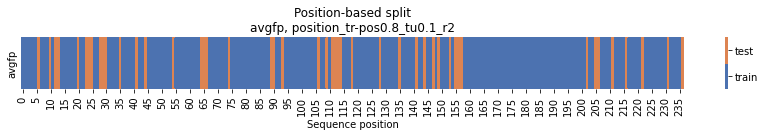

In [7]:
pos_split_heatmap(ds_name, seq_len, wt_ofs, basename(pos_split_dir), pos_split, pos_additional_info)

This visualization shows which positions were designated as training and which were designated as testing.

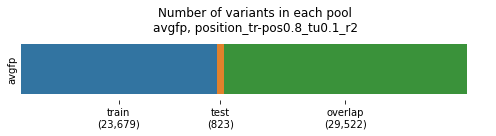

In [8]:
variants_pool_viz(ds_name, basename(pos_split_dir), pos_split, pos_additional_info)

This graphic shows how many variants are in each pool. The training pool gets split into a train and tune set. The test pool becomes the test set. 

In [9]:
# list out how many variants are in each set
for k, v in pos_split.items():
    print(k, len(v))

train 21311
tune 2368
test 823


## Visualize mutation-based splits
This heatmap shows which of the mutations present in the dataset are designated as training or testing. Mutations marked "n/a" are not present in the dataset. 

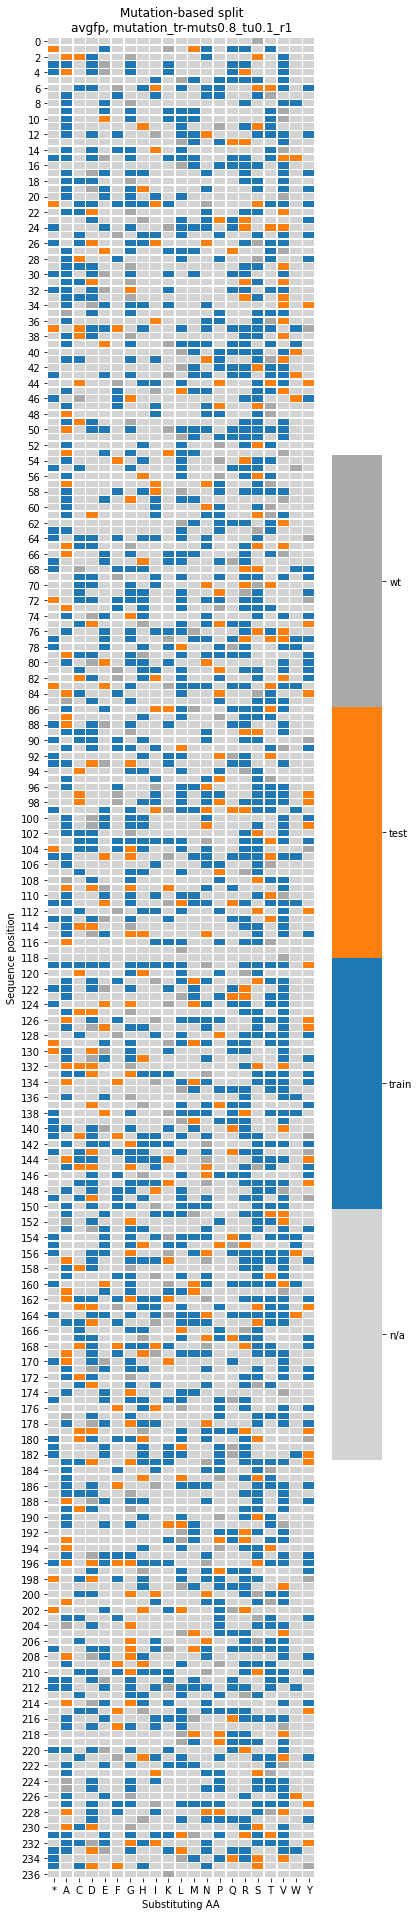

In [10]:
mut_split_heatmap(ds_name, wt_aa, seq_len, wt_ofs, basename(mut_split_dir), mut_split, mut_additional_info)

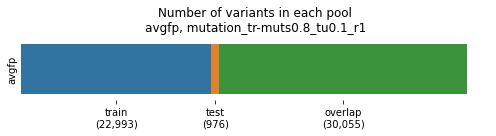

In [11]:
variants_pool_viz(ds_name, basename(mut_split_dir), mut_split, mut_additional_info)

In [12]:
# list out how many variants are in each set
for k, v in mut_split.items():
    print(k, len(v))

train 20693
tune 2300
test 976


# Visualizing the splits from the manuscript
In the manuscript, we performed six replicates for each of the five datasets. The exact splits are located in the `pub/splits` directory. Let's visualize some of the splits for GB1.

In [13]:
gb1_mut_split_dir_0 = "pub/splits/gb1/mutation_extrapolation/mutation_rep_0"
gb1_mut_split_dir_1 = "pub/splits/gb1/mutation_extrapolation/mutation_rep_1"

# loading the splits requires calling the typical sd.load_split_dir() function to load the train, tune, test sets, as well as
# sd.load_additional_info() to load the additional information about which mutations/positions designated as training/testing, etc
gb1_mut_0_split = sd.load_split_dir(gb1_mut_split_dir_0)
gb1_mut_0_additional_info = sd.load_additional_info(gb1_mut_split_dir_0)
gb1_mut_1_split = sd.load_split_dir(gb1_mut_split_dir_1)
gb1_mut_1_additional_info = sd.load_additional_info(gb1_mut_split_dir_1)

In [14]:
# also load positional splits
gb1_pos_split_dir_0 = "pub/splits/gb1/position_extrapolation/position_rep_0"
gb1_pos_split_dir_1 = "pub/splits/gb1/position_extrapolation/position_rep_1"

gb1_pos_0_split = sd.load_split_dir(gb1_pos_split_dir_0)
gb1_pos_0_additional_info = sd.load_additional_info(gb1_pos_split_dir_0)
gb1_pos_1_split = sd.load_split_dir(gb1_pos_split_dir_1)
gb1_pos_1_additional_info = sd.load_additional_info(gb1_pos_split_dir_1)

In [15]:
ds_name = "gb1"
# load some dataset metadata, can also change plotting functions to fetch this directly given the ds_name
wt_aa = constants.DATASETS[ds_name]["wt_aa"]
seq_len = len(constants.DATASETS[ds_name]["wt_aa"])
wt_ofs = constants.DATASETS[ds_name]["wt_ofs"]

With all the data loaded, we can visualize these splits.

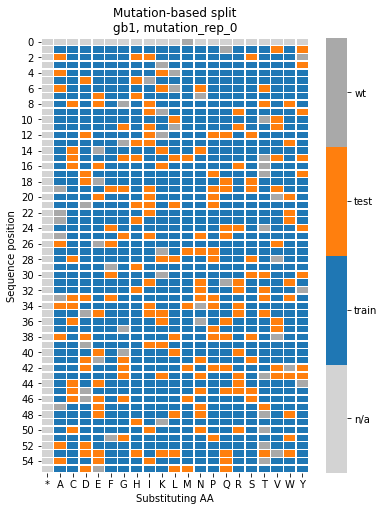

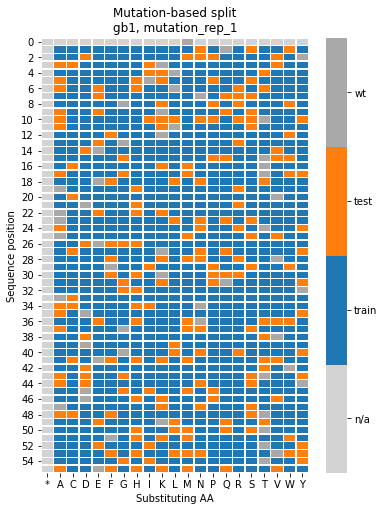

In [16]:
mut_split_heatmap(ds_name, wt_aa, seq_len, wt_ofs, basename(gb1_mut_split_dir_0), gb1_mut_0_split, gb1_mut_0_additional_info)
mut_split_heatmap(ds_name, wt_aa, seq_len, wt_ofs, basename(gb1_mut_split_dir_1), gb1_mut_1_split, gb1_mut_1_additional_info)

These heatmaps show which mutations were designated as training and which were designated as testing for the GB1 mutational split replicates 0 and 1. Note how the only "n/a"s are for subsituting AA of * (stop codon) and at sequence position 0, which were not tested in the source dataset. All other single mutations are designated as train or test because the dataset contains examples of all possible single mutations. 

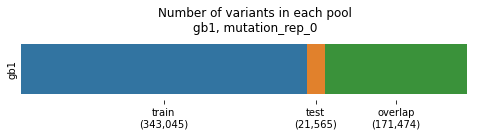

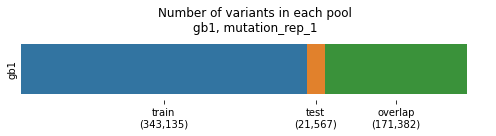

In [17]:
variants_pool_viz(ds_name, basename(gb1_mut_split_dir_0), gb1_mut_0_split, gb1_mut_0_additional_info)
variants_pool_viz(ds_name, basename(gb1_mut_split_dir_1), gb1_mut_1_split, gb1_mut_1_additional_info)

The pools contain similar numbers of variants across the two split replicates. 

We can also visualize the position splits of the the first two replicates.

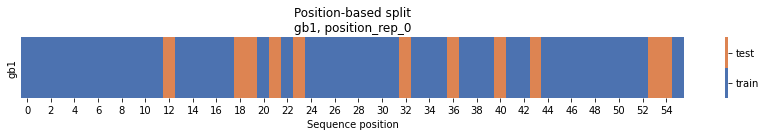

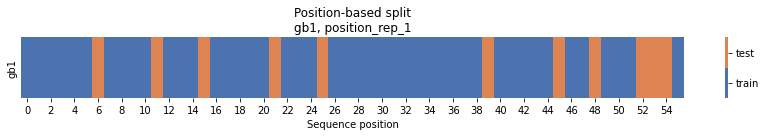

In [18]:
pos_split_heatmap(ds_name, seq_len, wt_ofs, basename(gb1_pos_split_dir_0), gb1_pos_0_split, gb1_pos_0_additional_info)
pos_split_heatmap(ds_name, seq_len, wt_ofs, basename(gb1_pos_split_dir_1), gb1_pos_1_split, gb1_pos_1_additional_info)